# Rock-paper-scissors with Keras/TensorFlow (DCT Type-II / DNN)

Original: 2019/1/19-21, Update: 2023/9/6

This notebook uses DCT Type-II coefficients as image features for DNN (Dense Neural Network).

Classification: rock, paper, 
scissors

## Preparing data set for DNN

In [1]:
DATA_FOLDER = '../STM32/Thermography/GUI/data/'
SCREENSHOTS_FOLDER = '../STM32/Thermography/GUI/screenshots/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

CUTOFF=6
LENGTH = 2 + 3 + 4 + 5 + 6 + 7
LENGTH

27

In [2]:
%matplotlib inline
%run ./zigzag.py

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct
import glob

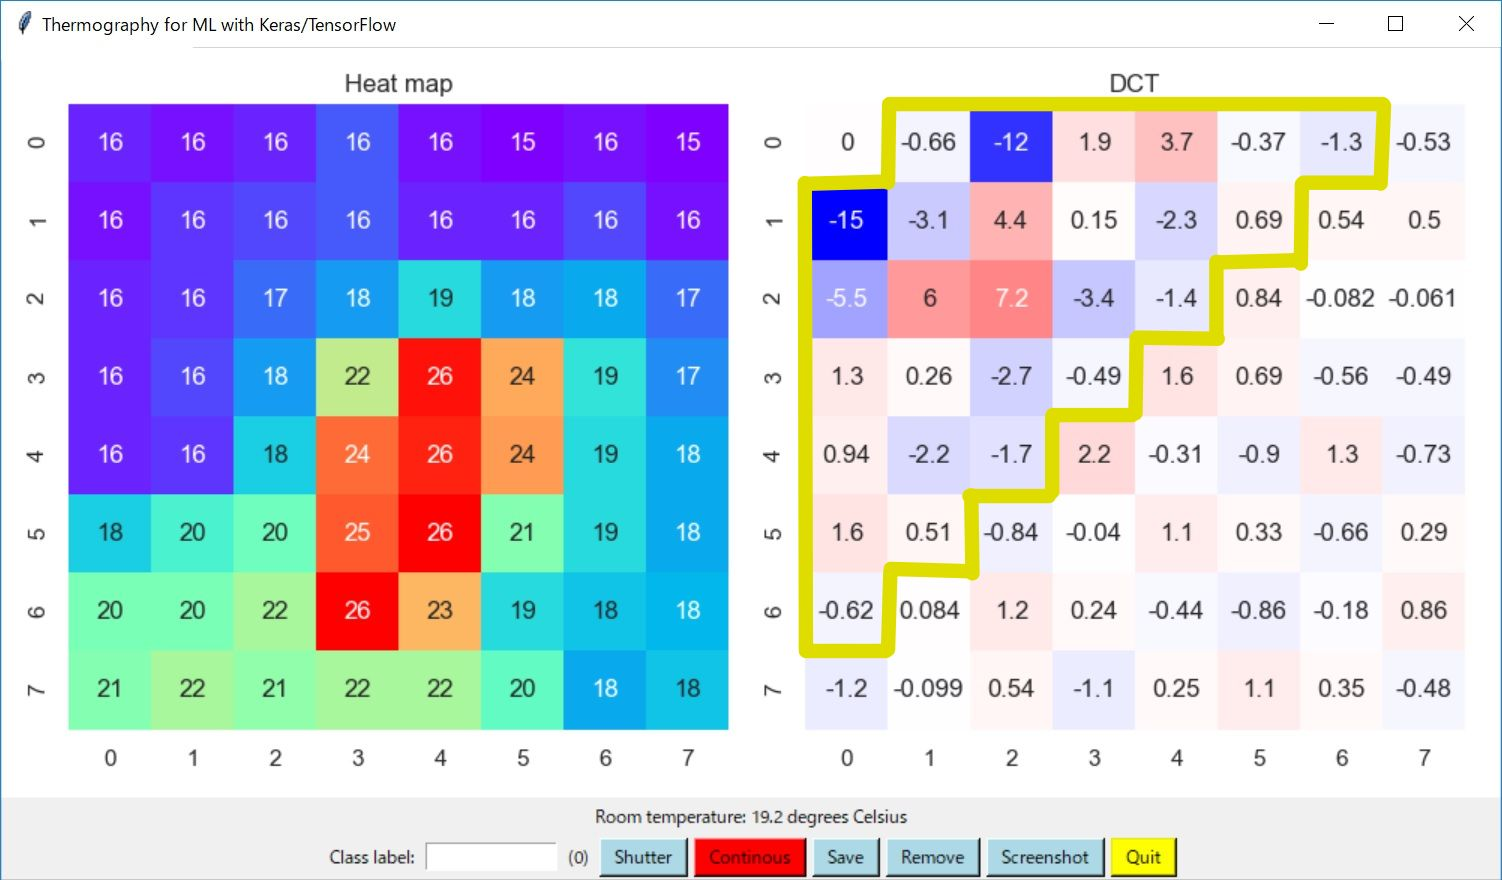

In [3]:
from IPython.display import Image
Image(filename=SCREENSHOTS_FOLDER + 'dct_higher_freqs.jpg', width=600, height=600)

In [4]:
data_files = glob.glob(DATA_FOLDER+'*.csv')
len(data_files)

142

In [5]:
data_files[0]

'../STM32/Thermography/GUI/data\\paper-20190104211500.csv'

In [6]:
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

class_labels

['paper', 'rock', 'scissors']

In [7]:
data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

In [8]:
training_set = []
test_set = []

In [9]:
for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

In [10]:
training_set[0]

(array([19.5, 19. , 19.2, 20.5, 26.5, 27.2, 21. , 18.8, 20.2, 18.2, 18.8,
        19. , 26.2, 27.5, 23.5, 19. , 19.2, 18. , 18.5, 19.5, 26.2, 27.2,
        26.2, 20. , 18.2, 18.2, 18.5, 21.8, 27.2, 28. , 26.5, 21. , 17.8,
        18.2, 18.5, 23. , 28. , 27.2, 25.5, 20. , 18. , 17.5, 18. , 21.2,
        26. , 25.2, 20.2, 19. , 17. , 18. , 18. , 18.8, 19.5, 19.5, 18.8,
        18.5, 17.8, 17.2, 17.5, 18.2, 18.5, 18.8, 18.2, 18. ]),
 1)

In [11]:
class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


In [12]:
ZIGZAG = True
train_data, train_labels = [], []
test_data, test_labels = [], []

In [13]:
def gen_data_labels(data_set):
    d = []  # data
    l = []  # labels
    for img, label in data_set:
        img = img.reshape(8,8)
        img = dct(dct(img, norm='ortho').T, norm='ortho').T
        img[0,0] = 0
        if ZIGZAG:
            img = zigzag_scan(img.flatten())[:LENGTH+1]
            img = img[1:LENGTH+1]
        else:
            img = img[:CUTOFF,:CUTOFF].flatten()
        img = pp.scale(img)  # Standardization
        d.append(img)
        l.append(label)
    d = np.array(d)
    l = np.array(l, dtype=np.uint8)
    return (d, l)

train_data, train_labels = gen_data_labels(training_set)
test_data, test_labels = gen_data_labels(test_set)

In [14]:
train_data[0]

array([-2.39019048,  1.84079171, -1.48319786, -0.57724528, -2.04474103,
        2.55723856, -0.386526  ,  1.18414658,  0.33093114,  0.37531912,
        0.2452171 ,  0.69389305,  1.21440031, -0.16736306, -0.24696321,
       -0.25695362, -0.46016726, -0.57987588, -0.06895053, -0.12716607,
        0.1296708 ,  0.10532221, -0.14182752,  0.16374806,  0.13522479,
       -0.08754484,  0.04280918])

In [15]:
train_labels[0]

1

In [16]:
from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

In [17]:
train_labels[0]

array([0., 1., 0.], dtype=float32)

## DNN model

In [18]:
LENGTH

27

In [19]:
from keras import layers
from keras import models

model = models.Sequential()

if ZIGZAG:
    model.add(layers.Dense(int(LENGTH*1.2), activation='relu', input_shape=(LENGTH,)))
else:
    model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu', input_shape=(CUTOFF**2,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                896       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 995 (3.89 KB)
Trainable params: 995 (3.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

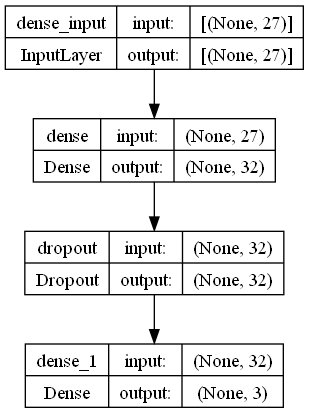

In [21]:
from IPython.display import SVG
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
EPOCHS = 400
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Epoch 1/400
3/3 [==============================] - 2s 206ms/step - loss: 1.6343 - accuracy: 0.3000 - val_loss: 1.1402 - val_accuracy: 0.3333
Epoch 2/400
3/3 [==============================] - 0s 29ms/step - loss: 1.4157 - accuracy: 0.3778 - val_loss: 1.1021 - val_accuracy: 0.4444
Epoch 3/400
3/3 [==============================] - 0s 34ms/step - loss: 1.4000 - accuracy: 0.4111 - val_loss: 1.0754 - val_accuracy: 0.4444
Epoch 4/400
3/3 [==============================] - 0s 34ms/step - loss: 1.4062 - accuracy: 0.3667 - val_loss: 1.0497 - val_accuracy: 0.4889
Epoch 5/400
3/3 [==============================] - 0s 32ms/step - loss: 1.4453 - accuracy: 0.3222 - val_loss: 1.0274 - val_accuracy: 0.5333
Epoch 6/400
3/3 [==============================] - 0s 31ms/step - loss: 1.4493 - accuracy: 0.3444 - val_loss: 1.0080 - val_accuracy: 0.5556
Epoch 7/400
3/3 [==============================] - 0s 32ms/step - loss: 1.3195 - accuracy: 0.3667 - val_loss: 0.9916 - val_accuracy: 0.5778
Epoch 8/400
3/3 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


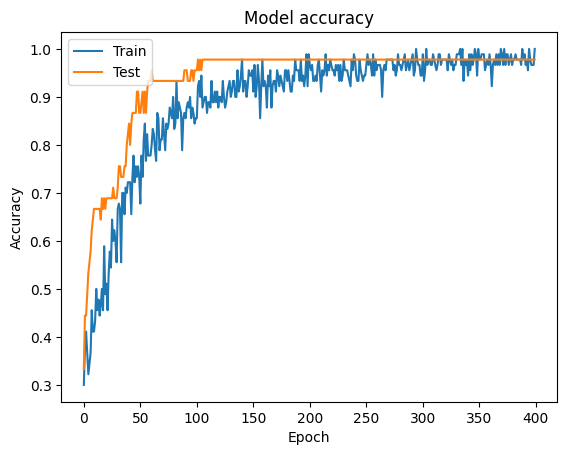

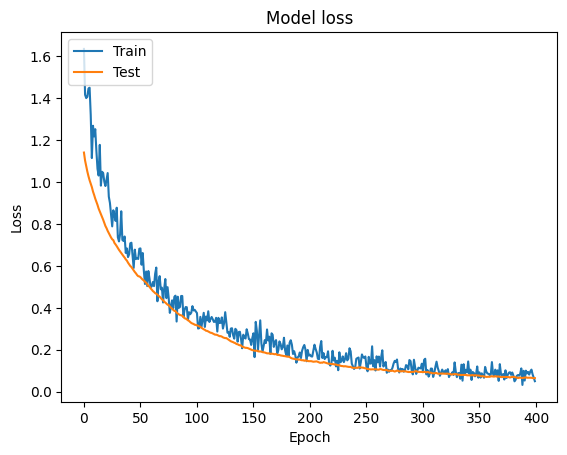

In [23]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [24]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_dct_{}.keras'.format(dt)
model.save(filename)

## load the model

In [25]:
del model
model = models.load_model(filename)

## Confirmation

In [26]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 27)

In [27]:
layer_outputs = [layer.output for layer in model.layers]

In [28]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

2/2 [==============================] - 0s 0s/step


In [29]:
class_labels

['paper', 'rock', 'scissors']

In [30]:
(activations[-1][:10]*100).astype(int)

array([[88, 11,  0],
       [99,  0,  0],
       [ 0, 99,  0],
       [83, 10,  5],
       [52,  0, 46],
       [99,  0,  0],
       [ 4, 95,  0],
       [ 0, 99,  0],
       [ 0, 99,  0],
       [ 0,  0, 99]])

In [31]:
test_labels[:10].astype(int)

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])